In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendp
import math

# Enable opendp features
opendp is still on development mode so to use all the code you must fist.

In [2]:
from opendp.mod import enable_features
enable_features('contrib')

# Histograms

### create dataset

In [3]:
# dataset size
N = 1000

# number of features
n_features = 4

data_features_1 = np.random.normal(10,2,size=(N) )
data_features_2= np.random.exponential(scale=2,size=(N))
dataset = np.array([data_features_1, data_features_2])

In [4]:
# count values
counts_1, bin_edges_1 = np.histogram(dataset[0], bins=10)
prop = counts_1 / counts_1.sum()

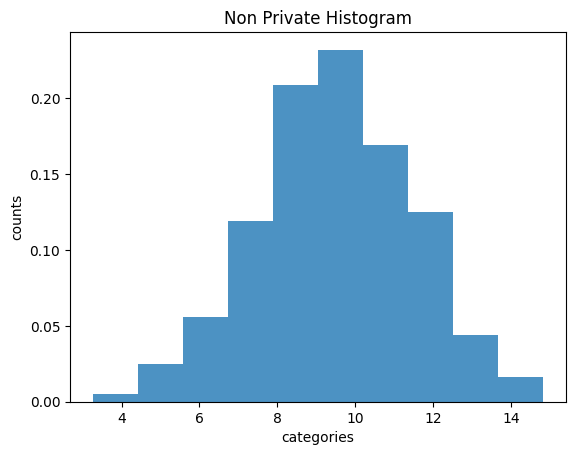

In [5]:
plt.figure()
plt.bar(height = prop, x = bin_edges_1[:-1],width=(bin_edges_1[1]-bin_edges_1[0]), alpha = 0.8)
plt.title("Non Private Histogram")
plt.xlabel("categories")
plt.ylabel("counts")
plt.show()
plt.close()

In [6]:
counts_2, bin_edges_2 = np.histogram(dataset[1], bins=10)
prop_2 = counts_2 / counts_2.sum()

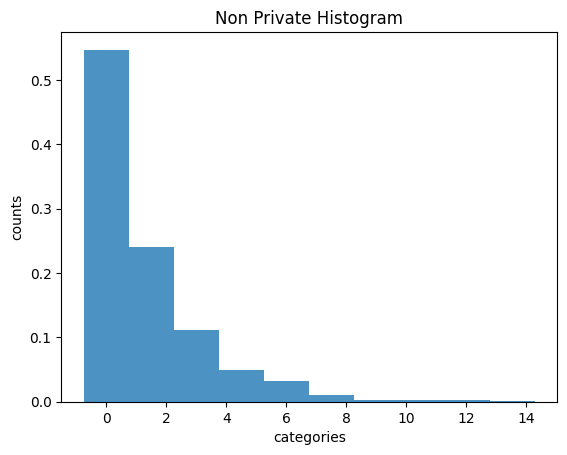

In [7]:
plt.figure()
plt.bar(height = prop_2, x = bin_edges_2[:-1],width=(bin_edges_2[1]-bin_edges_2[0]), alpha = 0.8)
plt.title("Non Private Histogram")
plt.xlabel("categories")
plt.ylabel("counts")
plt.show()
plt.close()

# Implement historgram
try to implement your own historgram function

In [8]:
def get_bins(data, number_of_bins):
    """
    define a function that create (number_of_bins + 1) bountaries from minimum to maxium value of the data.
    
    Hint: use np.linspace
    """
    minimum = np.min(data)
    maximum = np.max(data)
    bin_boundaries = np.linspace(start=minimum, stop=maximum, num=number_of_bins+1)
    return bin_boundaries

In [9]:
def count_in_bins(data, bin_boundaries):
    """
    define a function to count the values on each bin.
    the count of each bin represent the number of points lies on [bin[i],bin[i+1])
    expect last bin that should inlude last bountarie [bin[-2], bin[-1]]
    
    return: the count on each bin=(bin_edges[i],bin_edges[i+1])
    """
    counts = np.array([])
    for i in range(len(bin_boundaries)-2):
        values_in_bin = np.sum((data >= bin_boundaries[i]) & (data < bin_boundaries[i+1]))
        counts = np.append(counts,values_in_bin)
    
    count_last_bin = np.sum((data >= bin_boundaries[-2]) & (data <= bin_boundaries[-1]))
    counts = np.append(counts, count_last_bin)
    counts = counts.astype("int32")
    return counts

In [10]:
def my_histogram(data, number_of_bins):
    # create bins
    # you have to create n+1 boundaries in order to have n bins
    bin_boundaries = get_bins(data=data, number_of_bins=number_of_bins)
    
    # count values on each bin
    counts = count_in_bins(data=data, bin_boundaries=bin_boundaries)
    return counts, bin_boundaries

In [11]:
my_counts_1, my_bin_boundaries_1 = my_histogram(dataset[0], number_of_bins=10)
assert my_counts_1.sum() == N
my_counts_2, my_bin_boundaries_2 = my_histogram(dataset[1], number_of_bins=10)
assert my_counts_2.sum() == N

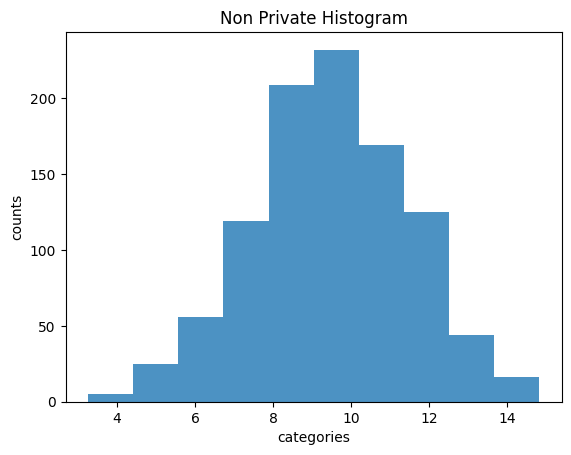

In [12]:
plt.figure()
plt.bar(height = my_counts_1,
        x = my_bin_boundaries_1[:-1],
        width=(my_bin_boundaries_1[1]-my_bin_boundaries_1[0]),
        alpha = 0.8)
plt.title("Non Private Histogram")
plt.xlabel("categories")
plt.ylabel("counts")
plt.show()
plt.close()

# Differentially Private Histograms
1. split the data in n diffent bins
2. count the value to each bin
3. add laplace noise to each bin
4. fix the wrong values - post-prossesing

In [13]:
from opendp.measurements import make_base_discrete_laplace
from opendp.mod import binary_search, binary_search_chain
from opendp.typing import VectorDomain, AllDomain

In [14]:
from opendp.measurements import binary_search

In [15]:
def my_private_histogram(data, number_of_bins, epsilon):
    """
    a function to implement histogram
    """
    # create bins
    # you have to create n+1 boundaries in order to have n bins
    bin_boundaries = get_bins(data=data, number_of_bins=number_of_bins)
    
    # count values on each bin
    counts = count_in_bins(data=data, bin_boundaries=bin_boundaries)
    
    # add desreete laplacian noise
    sensitivity = 1
    s = sensitivity/epsilon
    laplacian_mechanism = make_base_discrete_laplace(scale=s, D=VectorDomain[AllDomain[int]])

    counts = np.array(laplacian_mechanism(counts))

    # fix bad values
    mask = counts < 0
    counts[mask] = 0
    return counts, bin_boundaries

In [16]:
counts, bins = my_histogram(dataset[0], number_of_bins=10)
priv_counts, priv_bins = my_private_histogram(dataset[0], number_of_bins = 10, epsilon=0.1)

In [17]:
counts,priv_counts

(array([  5,  25,  56, 119, 209, 232, 169, 125,  44,  16], dtype=int32),
 array([  4,  33,  61, 134, 206, 228, 175, 136,  39,  15]))

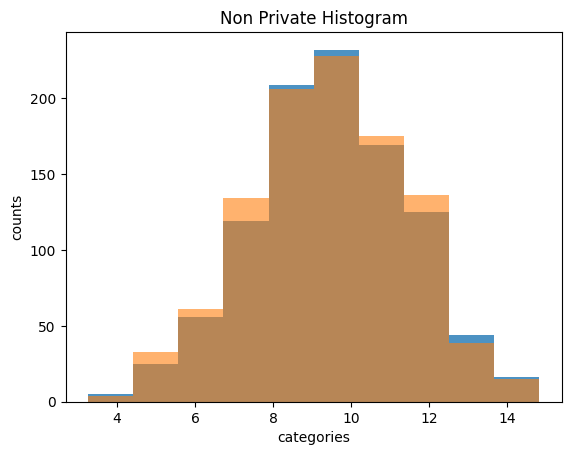

In [18]:
plt.figure()

plt.bar(height = counts,
        x = bins[:-1],
        width=(bins[1]-bins[0]),
        alpha = 0.8)

plt.bar(height = priv_counts,
        x = priv_bins[:-1],
        width=(priv_bins[1]-priv_bins[0]),
        alpha = 0.6)

plt.title("Non Private Histogram")
plt.xlabel("categories")
plt.ylabel("counts")
plt.show()
plt.close()

In [23]:
np.abs(counts_1/counts_1.sum() - priv_counts/priv_counts.sum()).sum()

0.076

In [24]:
error = []
for _ in range(100):
    priv_counts, bins = my_private_histogram(dataset[0], number_of_bins = 10, epsilon=0.1)
    tmp_error = np.abs(counts_1/counts_1.sum() - priv_counts/priv_counts.sum()).sum()
    error.append(tmp_error)
avg_error = np.mean(error)
std_of_error = np.std(error)

In [25]:
avg_error, std_of_error

(0.08711664372052332, 0.029277887797800144)

# check the error for different size of dataset and epsilon

In [26]:
dataset_sizes = [10, 100, 1000, 10000, 100000]
epsilons = [0.01, 0.1, 1.0 , 10]

In [27]:
dataset_error = []
for nsize in dataset_sizes:
    data_feature = np.random.normal(10, 2, size=(nsize) )
    dataset = np.array([data_feature])
    
    epsilon_error = np.array([])
    for epsilon in epsilons:
        counts, bins = my_histogram(dataset[0], number_of_bins = 10)
        
        error = []
        for _ in range(100):
            priv_counts, bins = my_private_histogram(dataset[0], number_of_bins = 10, epsilon=epsilon)
            tmp_error = np.abs(counts/counts.sum() - priv_counts/priv_counts.sum()).sum()
            error.append(tmp_error)
        avg_error = np.mean(error)
        epsilon_error = np.append(epsilon_error, avg_error)
    dataset_error += [epsilon_error]
dataset_error = np.array(dataset_error)

Text(0, 0.5, 'average error')

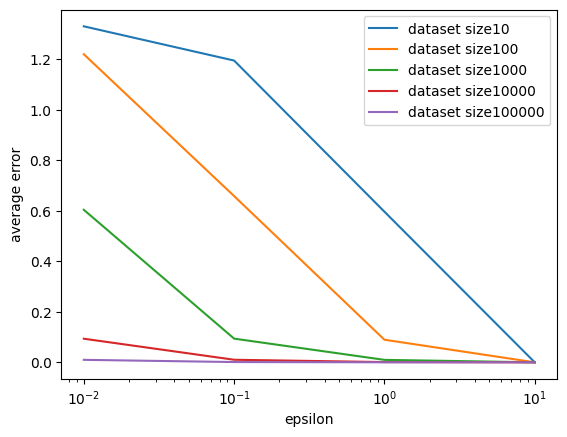

In [28]:
for i,_ in enumerate(dataset_error):
    plt.semilogx(epsilons, dataset_error[i],label = f"dataset size{dataset_sizes[i]}")
plt.legend()
plt.xlabel("epsilon")
plt.ylabel("average error")